## 1. Obtain and review raw data
<p>One day, my old running friend and I were chatting about our running styles, training habits, and achievements, when I suddenly realized that I could take an in-depth analytical look at my training. I have been using a popular GPS fitness tracker called <a href="https://runkeeper.com/">Runkeeper</a> for years and decided it was time to analyze my running data to see how I was doing.</p>
<p>Since 2012, I've been using the Runkeeper app, and it's great. One key feature: its excellent data export. Anyone who has a smartphone can download the app and analyze their data like we will in this notebook.</p>
<p><img src="https://assets.datacamp.com/production/project_727/img/runner_in_blue.jpg" alt="Runner in blue" title="Explore world, explore your data!"></p>
<p>After logging your run, the first step is to export the data from Runkeeper (which I've done already). Then import the data and start exploring to find potential problems. After that, create data cleaning strategies to fix the issues. Finally, analyze and visualize the clean time-series data.</p>
<p>I exported seven years worth of my training data, from 2012 through 2018. The data is a CSV file where each row is a single training activity. Let's load and inspect it.</p>

In [1]:
# Import pandas
import pandas as pd

# Define file containing dataset
runkeeper_file = 'datasets/cardioActivities.csv'

# Create DataFrame with parse_dates and index_col parameters 
df_activities = pd.read_csv(runkeeper_file, parse_dates=True, index_col='Date')

# First look at exported data: select sample of 3 random rows 
display(df_activities.sample(3))

# Print DataFrame summary
df_activities.info()

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2015-12-23 18:45:03,49f7059a-97c3-499e-9f42-85df1506aa90,Running,NaN,10.12,59:02,5:50,10.29,693.0,95,158.0,NaN,TomTom MySports Watch,2015-12-23-184503.gpx
2017-06-12 18:25:58,ba13aabc-d722-4803-9c1f-4e5043ecced6,Running,NaN,12.67,1:05:58,5:12,11.53,893.0,128,148.0,NaN,TomTom MySports Watch,2017-06-12-182558.gpx
2014-04-02 18:18:43,2a58f421-94a3-4e02-a4af-cf5e1fc25c9c,Running,NaN,6.22,32:00,5:09,11.65,446.0,33,NaN,NaN,NaN,2014-04-02-181843.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
Activity Id                 508 non-null object
Type                        508 non-null object
Route Name                  1 non-null object
Distance (km)               508 non-null float64
Duration                    508 non-null object
Average Pace                508 non-null object
Average Speed (km/h)        508 non-null float64
Calories Burned             508 non-null float64
Climb (m)                   508 non-null int64
Average Heart Rate (bpm)    294 non-null float64
Friend's Tagged             0 non-null float64
Notes                       231 non-null object
GPX File                    504 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 55.6+ KB


## 2. Data preprocessing
<p>Lucky for us, the column names Runkeeper provides are informative, and we don't need to rename any columns.</p>
<p>But, we do notice missing values using the <code>info()</code> method. What are the reasons for these missing values? It depends. Some heart rate information is missing because I didn't always use a cardio sensor. In the case of the <code>Notes</code> column, it is an optional field that I sometimes left blank. Also, I only used the <code>Route Name</code> column once, and never used the <code>Friend's Tagged</code> column.</p>
<p>We'll fill in missing values in the heart rate column to avoid misleading results later, but right now, our first data preprocessing steps will be to:</p>
<ul>
<li>Remove columns not useful for our analysis.</li>
<li>Replace the "Other" activity type to "Unicycling" because that was always the "Other" activity.</li>
<li>Count missing values.</li>
</ul>

In [2]:
# Define list of columns to be deleted
cols_to_drop = ['Friend\'s Tagged','Route Name','GPX File','Activity Id','Calories Burned', 'Notes']

# Delete unnecessary columns
df_activities.drop(columns=cols_to_drop, inplace=True)

# Count types of training activities
display(df_activities['Type'].value_counts())

# Rename 'Other' type to 'Unicycling'
df_activities['Type'] = df_activities['Type'].str.replace(pat='Other', repl='Unicycling')

# Count missing values for each column
df_activities.isnull().sum()

Running    459
Cycling     29
Walking     18
Other        2
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

## 3. Dealing with missing values
<p>As we can see from the last output, there are 214 missing entries for my average heart rate.</p>
<p>We can't go back in time to get those data, but we can fill in the missing values with an average value. This process is called <em>mean imputation</em>. When imputing the mean to fill in missing data, we need to consider that the average heart rate varies for different activities (e.g., walking vs. running). We'll filter the DataFrames by activity type (<code>Type</code>) and calculate each activity's mean heart rate, then fill in the missing values with those means.</p>

In [3]:
# Calculate sample means for heart rate for each training activity type 
avg_hr_run = df_activities[df_activities['Type'] == 'Running']['Average Heart Rate (bpm)'].mean()
avg_hr_cycle = df_activities[df_activities['Type'] == 'Cycling']['Average Heart Rate (bpm)'].mean()

# Split whole DataFrame into several, specific for different activities
df_run = df_activities[df_activities['Type'] == 'Running'].copy()
df_walk = df_activities[df_activities['Type'] == 'Walking'].copy()
df_cycle = df_activities[df_activities['Type'] == 'Cycling'].copy()

# Filling missing values with counted means  
df_walk['Average Heart Rate (bpm)'].fillna(110, inplace=True)
df_run['Average Heart Rate (bpm)'].fillna(int(avg_hr_run), inplace=True)
df_cycle['Average Heart Rate (bpm)'].fillna(int(avg_hr_cycle), inplace=True)

# Count missing values for each column in running data
df_run.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

## 4. Plot running data
<p>Now we can create our first plot! As we found earlier, most of the activities in my data were running (459 of them to be exact). There are only 29, 18, and two instances for cycling, walking, and unicycling, respectively. So for now, let's focus on plotting the different running metrics.</p>
<p>An excellent first visualization is a figure with four subplots, one for each running metric (each numerical column). Each subplot will have a different y-axis, which is explained in each legend. The x-axis, <code>Date</code>, is shared among all subplots.</p>

In [4]:
%matplotlib inline

# Import matplotlib, set style and ignore warning
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
plt.style.use('ggplot')
warnings.filterwarnings(
    action='ignore', module='matplotlib.figure', category=UserWarning,
    message=('This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.')
)


# Prepare data subsetting period from 2013 till 2018
runs_subset_2013_2018 = df_run['2018':'2013'] # The df_run index starts from the latest.

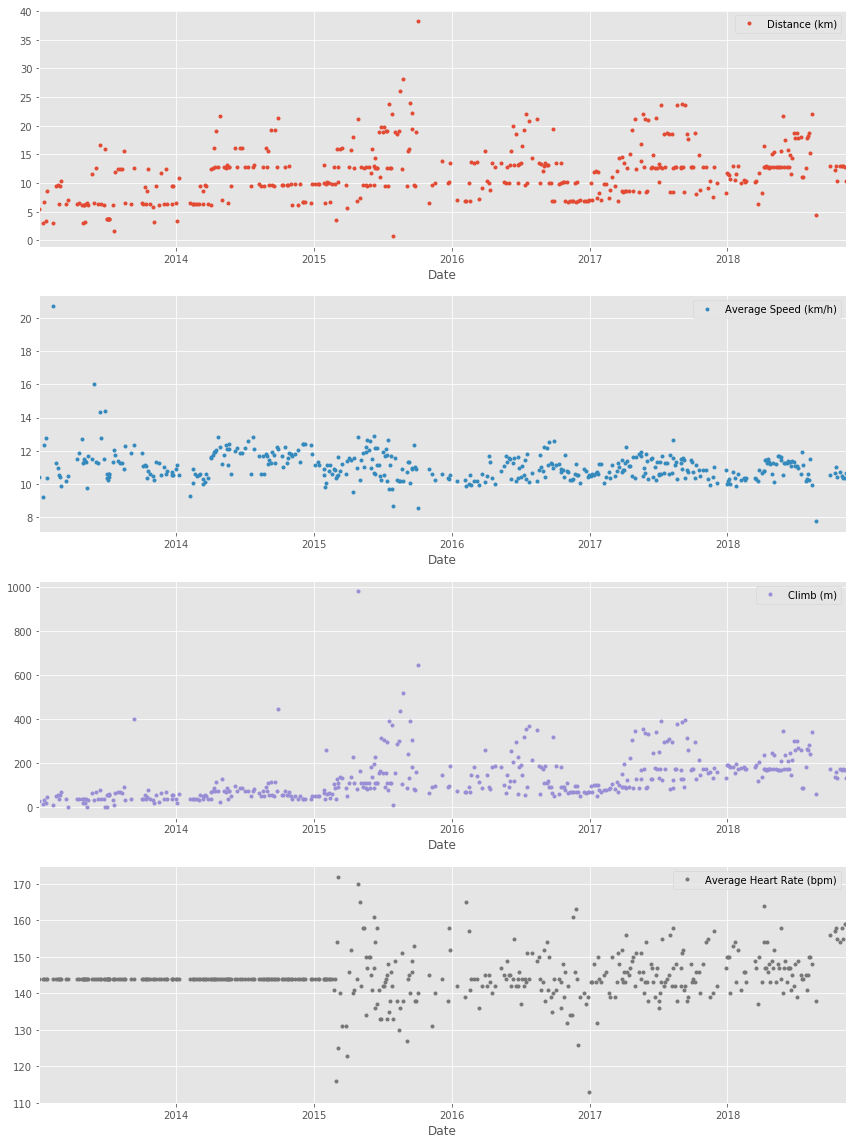

In [134]:
# Create, plot and customize in one step
runs_subset_2013_2018.plot(subplots=True,
                           sharex=False,
                           figsize=(12,16),
                           linestyle='none',
                           marker='o',
                           markersize=3,
                          )

# Show plot
plt.show()

## 5. Running statistics
<p>No doubt, running helps people stay mentally and physically healthy and productive at any age. And it is great fun! When runners talk to each other about their hobby, we not only discuss our results, but we also discuss different training strategies. </p>
<p>You'll know you're with a group of runners if you commonly hear questions like:</p>
<ul>
<li>What is your average distance?</li>
<li>How fast do you run?</li>
<li>Do you measure your heart rate?</li>
<li>How often do you train?</li>
</ul>
<p>Let's find the answers to these questions in my data. If you look back at plots in Task 4, you can see the answer to, <em>Do you measure your heart rate?</em> Before 2015: no. To look at the averages, let's only use the data from 2015 through 2018.</p>
<p>In pandas, the <code>resample()</code> method is similar to the <code>groupby()</code> method - with <code>resample()</code> you group by a specific time span. We'll use <code>resample()</code> to group the time series data by a sampling period and apply several methods to each sampling period. In our case, we'll resample annually and weekly.</p>

In [5]:
# Prepare running data for the last 4 years
runs_subset_2015_2018 = df_run['2018':'2015']

# Calculate annual statistics
print('How my average run looks in last 4 years:')
display(runs_subset_2015_2018.resample('A').mean())

# Calculate weekly statistics
print('Weekly averages of last 4 years:')
display(runs_subset_2015_2018.resample('W').mean().mean())

# Mean weekly counts
weekly_counts_average = runs_subset_2015_2018['Distance (km)'].resample('W').count().mean()
print('How many trainings per week I had on average:', weekly_counts_average)

How my average run looks in last 4 years:


,Distance (km),Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,
2015-12-31,13.602805,10.998902,160.170732,143.353659
2016-12-31,11.411667,10.837778,133.194444,143.388889
2017-12-31,12.935176,10.959059,169.376471,145.247059
2018-12-31,13.339063,10.777969,191.218750,148.125000


Weekly averages of last 4 years:


Distance (km)                12.518176
Average Speed (km/h)         10.835473
Climb (m)                   158.325444
Average Heart Rate (bpm)    144.801775
dtype: float64

How many trainings per week I had on average: 1.5


## 6. Visualization with averages
<p>Let's plot the long term averages of my distance run and my heart rate with their raw data to visually compare the averages to each training session. Again, we'll use the data from 2015 through 2018.</p>
<p>In this task, we will use <code>matplotlib</code> functionality for plot creation and customization.</p>

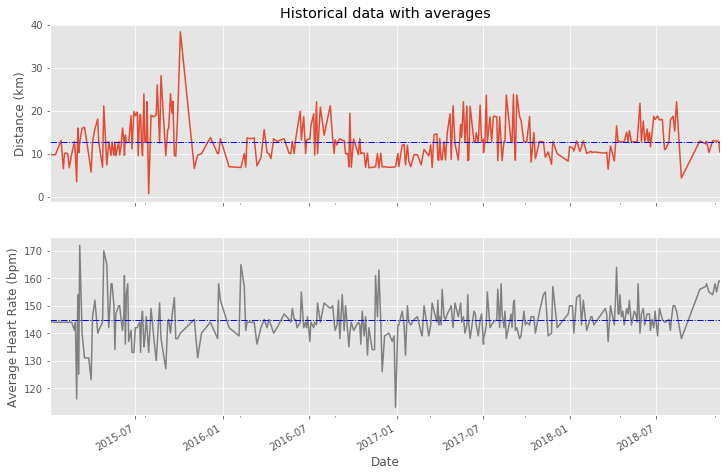

In [6]:
# Prepare data
runs_subset_2015_2018 = df_run['2018':'2015']
runs_distance = runs_subset_2015_2018['Distance (km)']
runs_hr = runs_subset_2015_2018['Average Heart Rate (bpm)']

# Create plot
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8))

# Plot and customize first subplot
runs_distance.plot(ax=ax1)
ax1.set(ylabel='Distance (km)', title='Historical data with averages')
ax1.axhline(runs_distance.mean(), color='blue', linewidth=1, linestyle='-.')

# Plot and customize second subplot
runs_hr.plot(ax=ax2, color='gray')
ax2.set(xlabel='Date', ylabel='Average Heart Rate (bpm)')
ax2.axhline(runs_hr.mean(), color='blue', linewidth=1, linestyle='-.')

# Show plot
plt.show()

## 7. Did I reach my goals?
<p>To motivate myself to run regularly, I set a target goal of running 1000 km per year. Let's visualize my annual running distance (km) from 2013 through 2018 to see if I reached my goal each year. Only stars in the green region indicate success.</p>

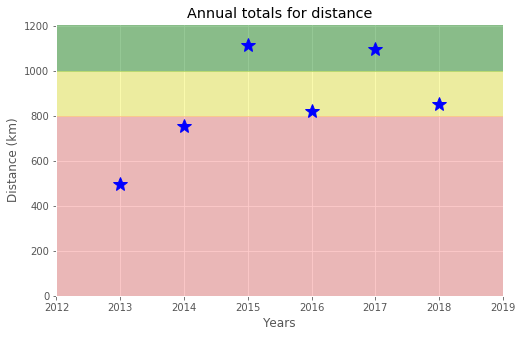

In [7]:
# Prepare data
df_run_dist_annual = df_run['2018':'2013']['Distance (km)'].resample('A').sum()

# Create plot
fig = plt.figure(figsize=(8,5))

# Plot and customize
ax = df_run_dist_annual.plot(marker='*', markersize=14, linewidth=0, color='blue')
ax.set(ylim=[0, 1210], 
       xlim=['2012','2019'],
       ylabel='Distance (km)',
       xlabel='Years',
       title='Annual totals for distance')

ax.axhspan(1000, 1210, color='green', alpha=0.4)
ax.axhspan(800, 1000, color='yellow', alpha=0.3)
ax.axhspan(0, 800, color='red', alpha=0.2)

# Show plot
plt.show()

## 8. Am I progressing?
<p>Let's dive a little deeper into the data to answer a tricky question: am I progressing in terms of my running skills? </p>
<p>To answer this question, we'll decompose my weekly distance run and visually compare it to the raw data. A red trend line will represent the weekly distance run.</p>
<p>We are going to use <code>statsmodels</code> library to decompose the weekly trend.</p>

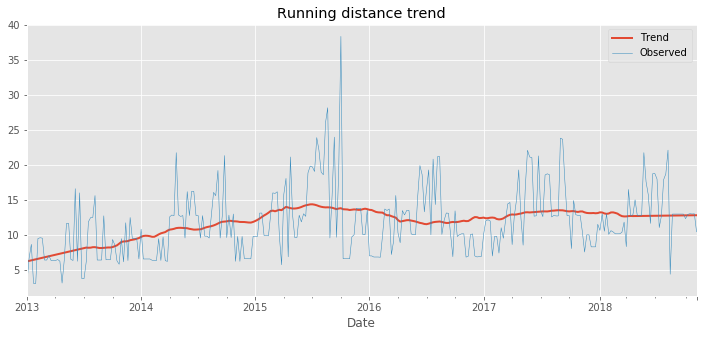

In [10]:
# Import required library
import statsmodels.api as sm

# Prepare data
df_run_dist_wkly = df_run['2018':'2013']['Distance (km)'].resample('W').bfill()
decomposed = sm.tsa.seasonal_decompose(df_run_dist_wkly, extrapolate_trend=1, period=52)

# Create plot
fig = plt.figure(figsize=(12,5))

# Plot and customize
ax = decomposed.trend.plot(label='Trend', linewidth=2)
ax = decomposed.observed.plot(label='Observed', linewidth=0.5)

ax.legend()
ax.set_title('Running distance trend')

# Show plot
plt.show()

## 9. Training intensity
<p>Heart rate is a popular metric used to measure training intensity. Depending on age and fitness level, heart rates are grouped into different zones that people can target depending on training goals. A target heart rate during moderate-intensity activities is about 50-70% of maximum heart rate, while during vigorous physical activity it’s about 70-85% of maximum.</p>
<p>We'll create a distribution plot of my heart rate data by training intensity. It will be a visual presentation for the number of activities from predefined training zones. </p>

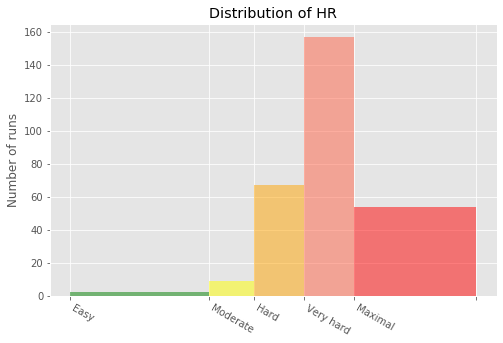

In [11]:
# Prepare data
hr_zones = [100, 125, 133, 142, 151, 173]
zone_names = ['Easy', 'Moderate', 'Hard', 'Very hard', 'Maximal']
zone_colors = ['green', 'yellow', 'orange', 'tomato', 'red']
df_run_hr_all = df_run['2018':'2015-03']['Average Heart Rate (bpm)']

# Create plot
fig, ax = plt.subplots(figsize=(8,5))

# Plot and customize
n, bins, patches = ax.hist(df_run_hr_all, bins=hr_zones, alpha=0.5)
for i in range(0, len(patches)):
    patches[i].set_facecolor(zone_colors[i])

ax.set(title='Distribution of HR', ylabel='Number of runs')
ax.xaxis.set(ticks=hr_zones)
ax.set_xticklabels(labels=zone_names, rotation=-30, ha='left')

# Show plot
plt.show()

## 10. Detailed summary report
<p>With all this data cleaning, analysis, and visualization, let's create detailed summary tables of my training. </p>
<p>To do this, we'll create two tables. The first table will be a summary of the distance (km) and climb (m) variables for each training activity. The second table will list the summary statistics for the average speed (km/hr), climb (m), and distance (km) variables for each training activity.</p>

In [12]:
# Concatenating three DataFrames
df_run_walk_cycle = df_run.append(df_walk).append(df_cycle).sort_index(ascending=False)
df_run_walk_cycle.head(3)

,Type,Distance (km),Duration,Average Pace,Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,,,,
2018-11-11 14:05:12,Running,10.44,58:40,5:37,10.68,130,159.0
2018-11-09 15:02:35,Running,12.84,1:14:12,5:47,10.39,168,159.0
2018-11-04 16:05:00,Running,13.01,1:15:16,5:47,10.37,171,155.0


In [13]:
dist_climb_cols, speed_col = ['Distance (km)', 'Climb (m)'], ['Average Speed (km/h)']

# Calculating total distance and climb in each type of activities
df_totals = df_run_walk_cycle.groupby('Type')[dist_climb_cols].sum()

print('Totals for different training types:')
display(df_totals)

# Calculating summary statistics for each type of activities 
df_summary = df_run_walk_cycle.groupby('Type')[dist_climb_cols + speed_col].describe()

# Combine totals with summary
for i in dist_climb_cols:
    df_summary[i, 'total'] = df_totals[i]

print('Summary statistics for different training types:')
df_summary.stack()

Totals for different training types:


,Distance (km),Climb (m)
Type,,
Cycling,680.58,6976
Running,5224.50,57278
Walking,33.45,349


Summary statistics for different training types:


Average Speed (km/h)     Climb (m)  Distance (km)
Type                                                            
Cycling 25%               16.980000    139.000000      15.530000
        50%               19.500000    199.000000      20.300000
        75%               21.490000    318.000000      29.400000
        count             29.000000     29.000000      29.000000
        max               24.330000    553.000000      49.180000
        mean              19.125172    240.551724      23.468276
        min               11.380000     58.000000      11.410000
        std                3.257100    128.960289       9.451040
        total                   NaN   6976.000000     680.580000
Running 25%               10.495000     54.000000       7.415000
        50%               10.980000     91.000000      10.810000
        75%               11.520000    171.000000      13.190000
        count            459.000000    459.000000     459.000000
        max               20.720000    982.000000      38.320000
        mean              11.056296    124.788671      11.382353
        min                5.770000      0.000000       0.760000
        std                0.953273    103.382177       4.937853
        total                   NaN  57278.000000    5224.500000
Walking 25%                5.555000      7.000000       1.385000
        50%                5.970000     10.000000       1.485000
        75%                6.512500     15.500000       1.787500
        count             18.000000     18.000000      18.000000
        max                6.910000    112.000000       4.290000
        mean               5.549444     19.388889       1.858333
        min                1.040000      5.000000       1.220000
        std                1.459309     27.110100       0.880055
        total                   NaN    349.000000      33.450000

## 11. Fun facts
<p>To wrap up, let’s pick some fun facts out of the summary tables and solve the last exercise.</p>
<p>These data (my running history) represent 6 years, 2 months and 21 days. And I remember how many running shoes I went through–7.</p>
<pre><code>FUN FACTS
- Average distance: 11.38 km
- Longest distance: 38.32 km
- Highest climb: 982 m
- Total climb: 57,278 m
- Total number of km run: 5,224 km
- Total runs: 459
- Number of running shoes gone through: 7 pairs
</code></pre>
<p>The story of Forrest Gump is well known–the man, who for no particular reason decided to go for a "little run." His epic run duration was 3 years, 2 months and 14 days (1169 days). In the picture you can see Forrest’s route of 24,700 km.  </p>
<pre><code>FORREST RUN FACTS
- Average distance: 21.13 km
- Total number of km run: 24,700 km
- Total runs: 1169
- Number of running shoes gone through: ...
</code></pre>
<p>Assuming Forest and I go through running shoes at the same rate, figure out how many pairs of shoes Forrest needed for his run.</p>
<p><img src="https://assets.datacamp.com/production/project_727/img/Forrest_Gump_running_route.png" alt="Forrest's route" title="Little run of Forrest Gump"></p>

In [15]:
# Count average shoes per lifetime (as km per pair) using our fun facts
average_shoes_lifetime = 5224 / 7

# Count number of shoes for Forrest's run distance
shoes_for_forrest_run = 24700 // average_shoes_lifetime

print('Forrest Gump would need {} pairs of shoes!'.format(shoes_for_forrest_run))

Forrest Gump would need 33.0 pairs of shoes!
